# Detección de COVID-19 mediante Radiografías de Tórax usando CNN

## Descripción del Proyecto

Este notebook implementa un sistema de clasificación para detectar COVID-19 a partir de radiografías de tórax. Utilizamos **Redes Neuronales Convolucionales (CNN)** en lugar de RNN porque:

- **RNN**: Diseñadas para datos **secuenciales** (texto, series temporales)
- **CNN**: Diseñadas para datos **espaciales** (imágenes), capturan patrones locales en imágenes

**Para clasificación de imágenes médicas, las CNN son el estándar.**

### Estructura: 1) Carga de datos 2) EDA 3) Preprocesamiento 4) Modelo CNN 5) Evaluación

---
## PASO 1: Instalación e Importación de Librerías

Importamos todas las bibliotecas necesarias para el análisis de datos, procesamiento de imágenes, construcción del modelo y visualización.

In [32]:
# Instalación de dependencias (ejecutar si es necesario)
# !pip install tensorflow matplotlib seaborn numpy pandas scikit-learn pillow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

# TensorFlow/Keras para el modelo
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Scikit-learn para métricas
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot')
sns.set_palette("husl")
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


---
## PASO 2: Carga y Exploración del Dataset

**Descripción:** Exploramos la estructura del dataset. Las imágenes están organizadas en carpetas:
- `train/covid19/` - Radiografías de pacientes con COVID-19
- `train/normal/` - Radiografías de pacientes sanos
- `test/covid19/` y `test/normal/` - Conjunto de prueba

In [2]:
# Rutas del dataset
BASE_DIR = Path("covid19_dataset")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

# Verificar que existan las carpetas
print("Estructura del dataset:")
for split in [TRAIN_DIR, TEST_DIR]:
    if split.exists():
        for class_folder in sorted(split.iterdir()):
            if class_folder.is_dir():
                count = len(list(class_folder.glob("*.jpg")))
                print(f"  {split.name}/{class_folder.name}: {count} imágenes")

Estructura del dataset:
  train/covid19: 176 imágenes
  train/normal: 176 imágenes
  test/covid19: 44 imágenes
  test/normal: 44 imágenes


### 2.1 Crear DataFrame con metadatos

Creamos un DataFrame que contiene la ruta de cada imagen y su etiqueta para facilitar el análisis.

In [3]:
def create_dataset_df(directory):
    """Crea DataFrame con rutas de imágenes y etiquetas."""
    data = []
    for class_name in ["covid19", "normal"]:
        class_path = directory / class_name
        if class_path.exists():
            for img_path in class_path.glob("*.jpg"):
                data.append({
                    "path": str(img_path),
                    "label": class_name,
                    "split": directory.name
                })
    return pd.DataFrame(data)

# Crear DataFrames
train_df = create_dataset_df(TRAIN_DIR)
test_df = create_dataset_df(TEST_DIR)
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Muestra del DataFrame:")
display(full_df.head(10))
print(f"\nTotal: {len(full_df)} imágenes")

Muestra del DataFrame:


,path,label,split
0,covid19_dataset/train/covid19/COVID19-117.jpg,covid19,train
1,covid19_dataset/train/covid19/COVID19-077.jpg,covid19,train
2,covid19_dataset/train/covid19/COVID19-088.jpg,covid19,train
3,covid19_dataset/train/covid19/COVID19-089.jpg,covid19,train
4,covid19_dataset/train/covid19/COVID19-062.jpg,covid19,train
5,covid19_dataset/train/covid19/COVID19-116.jpg,covid19,train
6,covid19_dataset/train/covid19/COVID19-100.jpg,covid19,train
7,covid19_dataset/train/covid19/COVID19-114.jpg,covid19,train
8,covid19_dataset/train/covid19/COVID19-128.jpg,covid19,train
9,covid19_dataset/train/covid19/COVID19-074.jpg,covid19,train



Total: 440 imágenes


---
## PASO 3: Análisis Exploratorio (EDA) - Gráficas para entender los datos

**Descripción:** Generamos visualizaciones clave para comprender la distribución y características del dataset.

### Gráfica 1: Distribución de clases (Train vs Test)

Muestra cuántas imágenes hay de cada clase en train y test. Importante para verificar balance de datos.

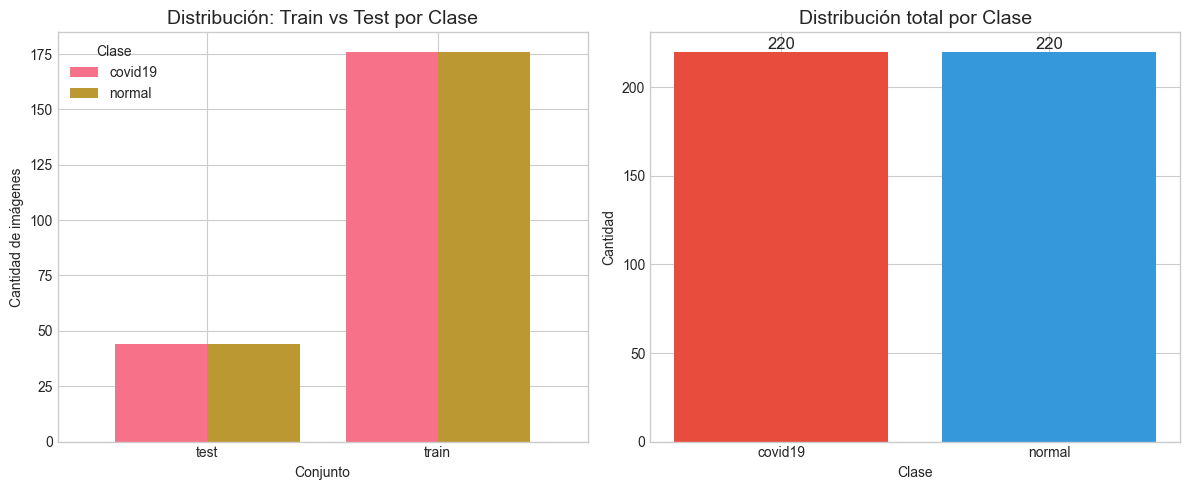

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfica por split (train/test)
split_counts = full_df.groupby(["split", "label"]).size().unstack(fill_value=0)
split_counts.plot(kind="bar", ax=axes[0], rot=0, width=0.8)
axes[0].set_title("Distribución: Train vs Test por Clase", fontsize=14)
axes[0].set_xlabel("Conjunto")
axes[0].set_ylabel("Cantidad de imágenes")
axes[0].legend(title="Clase")
axes[0].tick_params(axis='x', rotation=0)

# Gráfica de barras apiladas por clase
class_counts = full_df.groupby("label").size()
colors = ["#e74c3c", "#3498db"]  # Rojo para COVID, Azul para Normal
bars = axes[1].bar(class_counts.index, class_counts.values, color=colors)
axes[1].set_title("Distribución total por Clase", fontsize=14)
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Cantidad")
for bar in bars:
    height = bar.get_height()
    axes[1].annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                     ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Gráfica 2: Muestra de imágenes por clase

Visualizamos ejemplos de radiografías de cada clase para entender qué estamos clasificando.

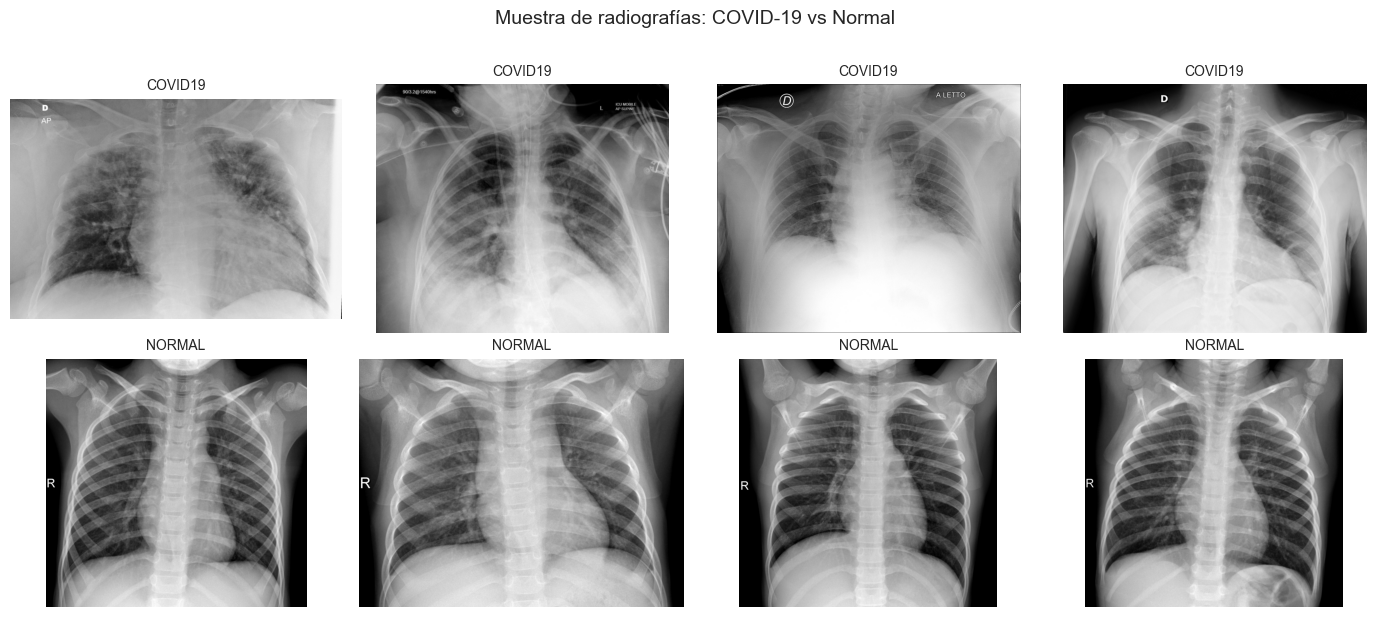

In [5]:
def show_sample_images(df, n_per_class=4, figsize=(14, 6)):
    """Muestra n imágenes de cada clase."""
    fig, axes = plt.subplots(2, n_per_class, figsize=figsize)
    
    for row, (label, color) in enumerate([("covid19", "Reds"), ("normal", "Blues")]):
        sample = df[df["label"] == label].sample(n=n_per_class, random_state=42)
        for col, (_, row_data) in enumerate(sample.iterrows()):
            img = Image.open(row_data["path"]).convert("L")
            axes[row, col].imshow(img, cmap="gray")
            axes[row, col].set_title(f"{label.upper()}", fontsize=10)
            axes[row, col].axis("off")
    
    plt.suptitle("Muestra de radiografías: COVID-19 vs Normal", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

show_sample_images(train_df, n_per_class=4)

### Gráfica 3: Distribución de dimensiones de las imágenes

Verificamos el tamaño de las imágenes para definir el input del modelo. Las CNNs requieren imágenes de tamaño fijo.

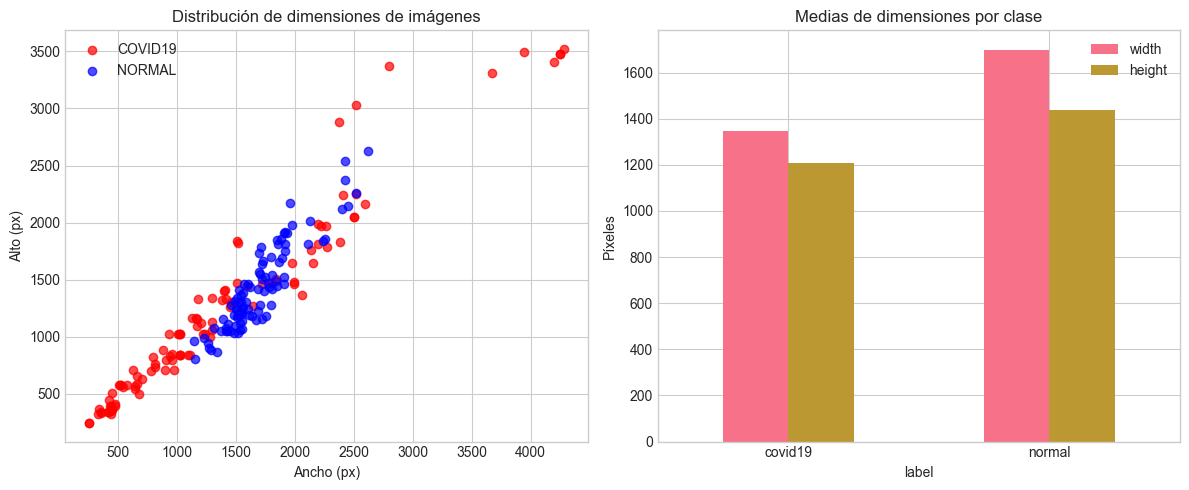

In [6]:
# Analizar dimensiones (muestra para no tardar mucho)
dims = []
for _, row in full_df.sample(min(200, len(full_df)), random_state=42).iterrows():
    img = Image.open(row["path"])
    dims.append({"width": img.width, "height": img.height, "label": row["label"]})
dims_df = pd.DataFrame(dims)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for label, color in [("covid19", "red"), ("normal", "blue")]:
    subset = dims_df[dims_df["label"] == label]
    axes[0].scatter(subset["width"], subset["height"], c=color, label=label.upper(), alpha=0.7)
axes[0].set_xlabel("Ancho (px)")
axes[0].set_ylabel("Alto (px)")
axes[0].set_title("Distribución de dimensiones de imágenes")
axes[0].legend()

dims_df.groupby("label")[["width", "height"]].mean().plot(kind="bar", ax=axes[1], rot=0)
axes[1].set_title("Medias de dimensiones por clase")
axes[1].set_ylabel("Píxeles")
plt.tight_layout()
plt.show()

---
## PASO 4: Preprocesamiento y Generadores de Datos

**Descripción:** Preparamos los datos para el entrenamiento:
1. **Resize**: 224×224 (formato MobileNetV2)
2. **Preprocesamiento**: preprocess_input de MobileNetV2 (valores [-1, 1])
3. **Data Augmentation** (solo train): Rotación, zoom, brillo, shear

In [33]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocesamiento para MobileNetV2 (espera valores 0-255, convierte a [-1, 1])
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,           # Más rotación (antes 20)
    width_shift_range=0.25,     # Más desplazamiento horizontal
    height_shift_range=0.25,    # Más desplazamiento vertical
    shear_range=0.3,            # Más distorsión (antes 0.2)
    zoom_range=0.3,             # Más zoom (antes 0.2)
    horizontal_flip=True,
    brightness_range=[0.7, 1.3], # Variación de brillo (radiografías pueden variar)
    fill_mode='nearest',
    validation_split=0.2
)

# Solo preprocesamiento para test (sin augmentación)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generadores
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['covid19', 'normal'],
    shuffle=True,
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['covid19', 'normal'],
    shuffle=False,
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['covid19', 'normal'],
    shuffle=False
)

print("Clases:", train_generator.class_indices)
print("Samples train:", train_generator.samples)
print("Samples val:", val_generator.samples)
print("Samples test:", test_generator.samples)

Found 282 images belonging to 2 classes.
Found 70 images belonging to 2 classes.


Found 88 images belonging to 2 classes.
Clases: {'covid19': 0, 'normal': 1}
Samples train: 282
Samples val: 70
Samples test: 88


---
## PASO 5: Construcción del Modelo CNN

**Descripción:** Transfer Learning con **MobileNetV2** (preentrenado en ImageNet):

- Base congelada: extrae características ya aprendidas de millones de imágenes
- Solo entrenamos la "cabeza" clasificadora (Dense + Dropout)
- Requiere mucho menos datos que una CNN desde cero

In [34]:
# TRANSFER LEARNING: MobileNetV2 preentrenado en ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar la base (no entrenar esos pesos)
base_model.trainable = False

# Añadir cabeza clasificadora
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

---
## PASO 6: Entrenamiento del Modelo

**Callbacks (anti-overfitting):**
- **EarlyStopping**: patience=5 — para antes si val_loss no mejora
- **ReduceLROnPlateau**: patience=3 — reduce LR más rápido
- **ModelCheckpoint**: Guarda el mejor modelo según val_loss

In [35]:
# EarlyStopping MÁS ESTRICTO: para con 5 épocas sin mejora (antes 10)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

# ReduceLROnPlateau más agresivo: reduce LR con 3 épocas sin mejora (antes 5)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

# ModelCheckpoint: guarda el mejor modelo según val_loss
checkpoint = ModelCheckpoint(
    'best_covid_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

EPOCHS = 50
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6125 - loss: 0.7071
Epoch 1: val_loss improved from None to 0.25277, saving model to best_covid_model.keras

Epoch 1: finished saving model to best_covid_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 644ms/step - accuracy: 0.7730 - loss: 0.4792 - val_accuracy: 0.9000 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9227 - loss: 0.2229
Epoch 2: val_loss improved from 0.25277 to 0.11330, saving model to best_covid_model.keras

Epoch 2: finished saving model to best_covid_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - accuracy: 0.9184 - loss: 0.2126 - val_accuracy: 0.9857 - val_loss: 0.1133 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9474 - loss: 0.1536
Epoch 3: val_loss did not improve from 0.11330
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.9433 - loss: 0.1393 - val_accuracy: 0.9429 - val_loss: 0.1300 - learning_ra

---
## PASO 7: Gráficas del Entrenamiento

**Descripción:** Visualizamos la evolución del entrenamiento:
- **Loss (Pérdida)**: Debe disminuir; si val_loss sube mientras train_loss baja → overfitting
- **Accuracy (Precisión)**: Porcentaje de predicciones correctas

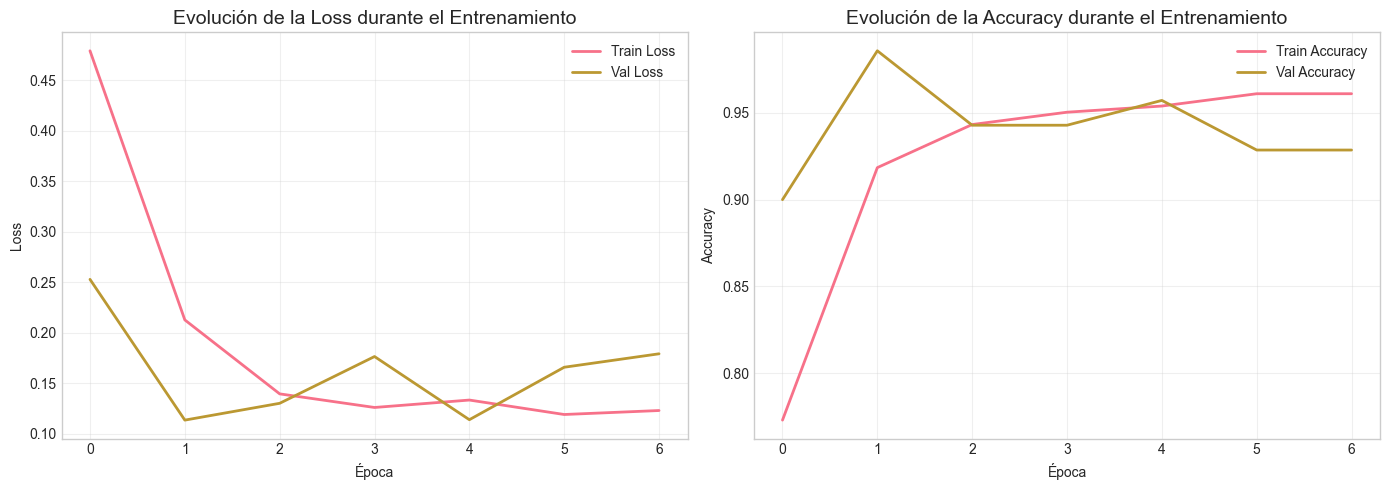

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Evolución de la Loss durante el Entrenamiento', fontsize=14)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfica de Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Evolución de la Accuracy durante el Entrenamiento', fontsize=14)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Gráfica combinada: Loss y Accuracy en un solo panel

Útil para comparar ambas métricas y detectar overfitting (val_loss sube mientras train mejora).

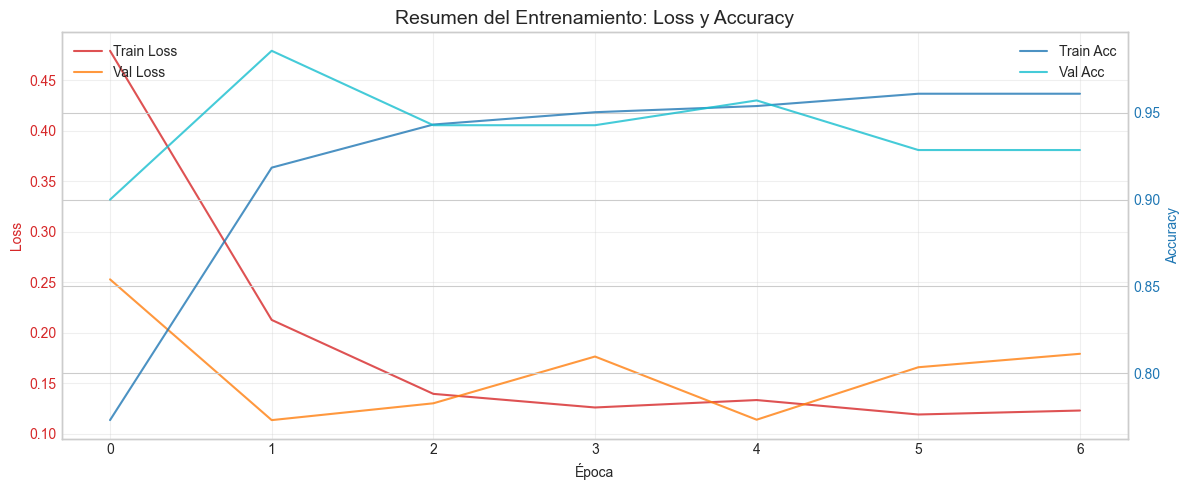

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_xlabel('Época')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(history.history['loss'], color='tab:red', label='Train Loss', alpha=0.8)
ax1.plot(history.history['val_loss'], color='tab:orange', label='Val Loss', alpha=0.8)
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
ax2.plot(history.history['accuracy'], color='tab:blue', label='Train Acc', alpha=0.8)
ax2.plot(history.history['val_accuracy'], color='tab:cyan', label='Val Acc', alpha=0.8)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

plt.title('Resumen del Entrenamiento: Loss y Accuracy', fontsize=14)
plt.tight_layout()
plt.show()

---
## PASO 8: Evaluación en el Conjunto de Test

Evaluamos el modelo con datos nunca vistos durante el entrenamiento.

In [38]:
test_generator.reset()
test_results = model.evaluate(test_generator)
print(f"\nResultados en Test:")
print(f"  Loss: {test_results[0]:.4f}")
print(f"  Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")

# Predicciones
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).flatten()
y_true = test_generator.classes

# Reporte de clasificación
print("\n" + "="*50)
print("Reporte de Clasificación (Test):")
print("="*50)
print(classification_report(y_true, y_pred, target_names=['COVID-19', 'Normal']))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9773 - loss: 0.0588

Resultados en Test:
  Loss: 0.0588
  Accuracy: 0.9773 (97.73%)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step

Reporte de Clasificación (Test):
              precision    recall  f1-score   support

    COVID-19       0.98      0.98      0.98        44
      Normal       0.98      0.98      0.98        44

    accuracy                           0.98        88
   macro avg       0.98      0.98      0.98        88
weighted avg       0.98      0.98      0.98        88



### Matriz de Confusión

- **Verdaderos Positivos (TP)**: COVID correctamente identificado
- **Falsos Negativos (FN)**: COVID clasificado como Normal (peligroso en medicina)
- **Falsos Positivos (FP)**: Normal clasificado como COVID
- **Verdaderos Negativos (TN)**: Normal correctamente identificado

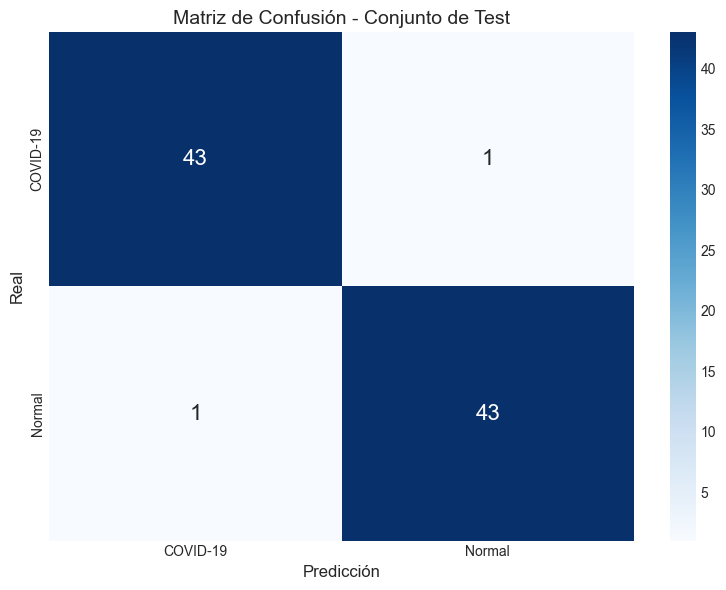

In [39]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['COVID-19', 'Normal'],
            yticklabels=['COVID-19', 'Normal'],
            annot_kws={'size': 16})
ax.set_xlabel('Predicción', fontsize=12)
ax.set_ylabel('Real', fontsize=12)
ax.set_title('Matriz de Confusión - Conjunto de Test', fontsize=14)
plt.tight_layout()
plt.show()

### Curva ROC (Receiver Operating Characteristic)

La curva ROC muestra el trade-off entre **Tasa de Verdaderos Positivos** (sensibilidad) y **Tasa de Falsos Positivos** (1 - especificidad) para distintos umbrales de decisión. El **AUC** (área bajo la curva) mide la capacidad discriminativa del modelo: 1.0 = perfecto, 0.5 = azar.

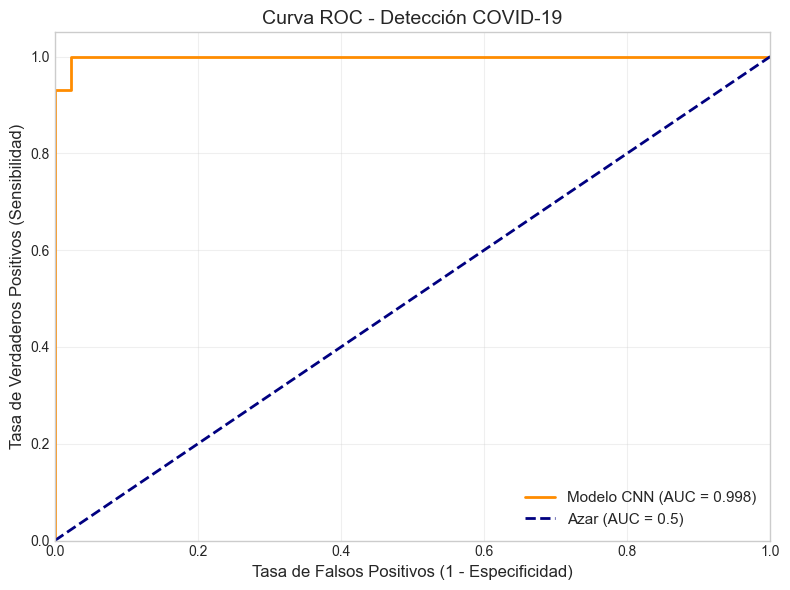

In [40]:
# Curva ROC: predictions contiene las probabilidades (sin umbral 0.5)
y_proba = predictions.flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
auc_score = roc_auc_score(y_true, y_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Modelo CNN (AUC = {auc_score:.3f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
ax.set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
ax.set_title('Curva ROC - Detección COVID-19', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## PASO 9: Guardar el Modelo (Opcional)

Guarda el modelo entrenado para uso posterior sin necesidad de reentrenar.

In [41]:
# Descomentar para guardar:
# model.save("covid19_cnn_model.keras")
# print("Modelo guardado como covid19_cnn_model.keras")

---
## Resumen Ejecutivo - Flujo Completo del Proyecto

| Paso | Descripción detallada |
|------|------------------------|
| **1** | **Importación**: TensorFlow (modelo), Pandas (datos), Matplotlib/Seaborn (gráficas), PIL (imágenes) |
| **2** | **Carga**: Dataset en `train/` y `test/` con subcarpetas `covid19/` y `normal/` |
| **3** | **EDA**: Gráficas de distribución de clases, muestras de imágenes, dimensiones de píxeles |
| **4** | **Preprocesamiento**: Resize a 224×224, normalización 0-1, data augmentation (rotación, zoom, flip) |
| **5** | **Modelo CNN**: 4 bloques Conv2D+Pool+Dropout, clasificador binario final |
| **6** | **Entrenamiento**: EarlyStopping y ReduceLROnPlateau para evitar overfitting |
| **7** | **Gráficas**: Loss y Accuracy por época (train vs validación) |
| **8** | **Evaluación**: Reporte de clasificación, matriz de confusión en test |

**Nota**: Este modelo es educativo. Para uso clínico real se requieren datasets más grandes y validación médica.